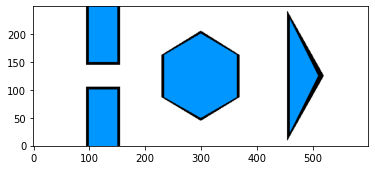

Enter Initial Node X and Y, separated by spaces: 
1 1
Enter Goal Node X and Y, separated by spaces: 
599 125
Dijkstra Search Starting!!!!
goal has been reached
total cost is: 723.3999999999958
The search was completed in  596.0289279000003  seconds.


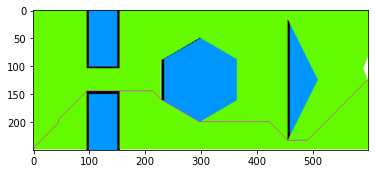

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
import timeit
import queue
from queue import PriorityQueue
##-----------------corners of obstacles to colour the map-----------------##
# Corners of the bottom rectangle to draw the map
BRC_X = [100, 100, 150, 150]
BRC_Y = [100, 0, 0, 100]
BR = np.array(list(zip(BRC_X, BRC_Y)))
# Corners of the bottom rectangle with clearance for boundary
BRC_X_CLR = [95, 95, 155, 155]
BRC_Y_CLR = [105, 0, 0, 105]
BR_CLR = np.array(list(zip(BRC_X_CLR, BRC_Y_CLR)))

# Corners of the top rectangle to draw the map
TRC_x = [100, 100, 150, 150]
TRC_y = [250, 150, 150, 250]
TR = np.array(list(zip(TRC_x, TRC_y)))

# Corners of the top rectangle with clearance for boundary
TRC_x_CLR = [95, 95, 155, 155]
TRC_y_CLR = [250, 145, 145, 250]
TR_CLR = np.array(list(zip(TRC_x_CLR, TRC_y_CLR)))

# Corners of the hexagon to draw the map
Hexagon_Points = np.array([[300,50],[364,87],[364,162],[300,200],[235,162],[235,87]], dtype=np.int32)

# Corners of the hexagon with clearance for boundary
Hexagon_Points_CLR = np.array([[300,45],[369,87],[369,162],[300,205],[230,162],[230,87]], dtype=np.int32)

# Corners of the triangle to draw the map
TRGL_x = [460, 460, 510]
TRGL_y = [25, 225, 125]
TRGL = np.array(list(zip(TRGL_x, TRGL_y)))

# Corners of the triangle with clearance for boundary
TRGL_x_CLR = [455, 455, 520]
TRGL_y_CLR = [10, 240, 125]
TRGL_CLR = np.array(list(zip(TRGL_x_CLR, TRGL_y_CLR)))

##-----------------HALF PLANE EQUATIONS TO MAKE OBSTACLES----------------##
'''This function creates the map using half plane method.
    Args - width, height //boundary of the map
    Returns - obs_space an array which returns all the nodes which are obstacles'''
def half_plane_obstcles(width, height):
    #define obstacle space a (0,0)
    obs_space = np.zeros((height, width))
    
    #running a for loop for half plane functions to get all the as obstacles
    for y in range(height):
        for x in range(width):
            #bottom rectangle equations // r14 is not required as it lies within the boundary
            r11, r12, r13 = x-100, y-100, x-150
            #top rectangle equations // r24 is not required as it lies within the boundary
            r21, r23, r24 = x-100, x-150, y-150
            #equations for six lines of hexagon
            h1, h2, h3, h4, h5, h6 = x-235.04, y-0.58*x-26.82, y+0.58*x-373.21, x-364.95, y-0.58*x+123.21, y+0.58*x-223.18
            #equations for triangle
            t1, t2, t3 = x-460, y+2*x-1145, y-2*x+895
            
            #defining the boundary conditions for each line, to make an enclosed space, and then adding that to obs_space
            if (h6>0 and h5>0 and h4<0 and h3<0 and h2<0 and h1>0) or (r11>0 and r12<0 and r13<0) or (r21>0 and r23<0 and r24>0) or (t1>0 and t2<0 and t3>0):
                obs_space[y, x] = 1
            
            #bottom rectangle with clearance equations
            r11_c, r12_c, r13_c, r14_c = x+5-100, y-5-100, x-5-150, y-0
            #top rectangle with clearance equations
            r21_c, r22_c, r23_c, r24_c = x+5-100, y-250, x-5-150, y+5-150
            #equations for six lines of hexagon with clearance
            h1_c, h2_c, h3_c, h4_c, h5_c, h6_c = x+6.5-235.04, y-0.58*x-26.82, y+0.58*x-373.21, x-364.95, y-0.58*x+123.21, y+0.58*x-223.18
            #equations for six lines of hexagon with clearance
            t1_c, t2_c, t3_c = x+5-460, y+2*x-1145, y-2*x+895
            
            #defining the boundary conditions for each line, to make an enclosed space, and then adding that to obs_space
            if (h6_c>0 and h5_c>0 and h4_c<0 and h3_c<0 and h2_c<0 and h1_c>0) or (r11_c>0 and r12_c<0 and r13_c<0) or (r21_c>0 and r23_c<0 and r24_c>0) or (t1_c>0 and t2_c<0 and t3_c>0):
                obs_space[y, x] = 2

    return obs_space

#given size of the map
width = 600
height = 250

#making an array to store the obstacle space
obs_space = half_plane_obstcles(width, height)

##---------------------------------NODES------------------------------------##
'''This is the node class which is used to represent nodes in a search algorithm, 
there are four subfunctions to retrieve the state, move, parent, parent's state, and cost to come of the node '''
class Node():
    #INITIALIZE THE CLASS
    def __init__(self, state, parent, move, C2C):
        self.state, self.parent, self.move, self.C2C = state, parent, move, C2C
    #Retrieve the state of the node
    def return_state(self):
        return self.state
    
    #Move the node 
    def move_node(self):
        return self.move
    
    #return the parent node for back tracking
    def find_parent(self):
        return self.parent
    
    #retrieve the state of the parent nodes
    def find_parentState(self):
        return self.parent.return_state() if self.find_parent() else None
    
    #retrieve the path from the start node to the current node.
    #follow the parents from start node to current node and store the path
    def path_tracker(self):
        moves, path = [], []
        node = self
        while node.move_node():
            moves.append(node.move_node())
            path.append(node)
            node = node.find_parent()
        path.append(node)
        return moves[::-1], path[::-1]
    
    #return the cost to get to the node
    def node_cost(self):
        return self.C2C
    
    #compare the 2 nodes based on their cost 
    def __lt__(self, other):
        return self.C2C < other.C2C
    
##---------------------------series of functions for movement------------------##    
'''these set of subfunctions define all the possible moves that a robot may make
whilst checking for all the conditions that the robot has to avoid'''
#this function moves the node in upward direction, while also checking for obstacles,boundary,
#or weather or not it is the same as its parent
def Up(x, y, obs_space, parent_state):
    possible_moves = []
    move_x, move_y = x, y+1
    if not (check_obstacle(move_x, move_y, obs_space) or check_boundary(move_x, move_y) or parent_state == [move_x, move_y]):
        possible_moves.append('Up')
    return possible_moves

#this function moves the node in upward and rightward direction, while also checking for obstacles,boundary,
#or weather or not it is the same as its parent
def UpRight(x, y, obs_space, parent_state):
    possible_moves = []
    move_x, move_y = x+1, y+1
    if not (check_obstacle(move_x, move_y, obs_space) or check_boundary(move_x, move_y) or parent_state == [move_x, move_y]):
        possible_moves.append('UpRight')
    return possible_moves

#this function moves the node in rightward direction, while also checking for obstacles,boundary,
#or weather or not it is the same as its parent
def Right(x, y, obs_space, parent_state):
    possible_moves = []
    move_x, move_y = x+1, y
    if not (check_obstacle(move_x, move_y, obs_space) or check_boundary(move_x, move_y) or parent_state == [move_x, move_y]):
        possible_moves.append('Right')
    return possible_moves

#this function moves the node in downward and rightward direction, while also checking for obstacles,boundary,
#or weather or not it is the same as its parent
def DownRight(x, y, obs_space, parent_state):
    possible_moves = []
    move_x, move_y = x+1, y-1
    if not (check_obstacle(move_x, move_y, obs_space) or check_boundary(move_x, move_y) or parent_state == [move_x, move_y]):
        possible_moves.append('DownRight')
    return possible_moves

#this function moves the node in downward direction, while also checking for obstacles,boundary,
#or weather or not it is the same as its parent
def Down(x, y, obs_space, parent_state):
    possible_moves = []
    move_x, move_y = x, y-1
    if not (check_obstacle(move_x, move_y, obs_space) or check_boundary(move_x, move_y) or parent_state == [move_x, move_y]):
        possible_moves.append('Down')
    return possible_moves

#this function moves the node in downward and leftward direction, while also checking for obstacles,boundary,
#or weather or not it is the same as its parent
def DownLeft(x, y, obs_space, parent_state):
    possible_moves = []
    move_x, move_y = x-1, y-1
    if not (check_obstacle(move_x, move_y, obs_space) or check_boundary(move_x, move_y) or parent_state == [move_x, move_y]):
        possible_moves.append('DownLeft')
    return possible_moves

#this function moves the node in leftward direction, while also checking for obstacles,boundary,
#or weather or not it is the same as its parent
def Left(x, y, obs_space, parent_state):
    possible_moves = []
    move_x, move_y = x-1, y
    if not (check_obstacle(move_x, move_y, obs_space) or check_boundary(move_x, move_y) or parent_state == [move_x, move_y]):
        possible_moves.append('Left')
    return possible_moves

#this function moves the node in upward and leftward direction, while also checking for obstacles,boundary,
#or weather or not it is the same as its parent
def UpLeft(x, y, obs_space, parent_state):
    possible_moves = []
    move_x, move_y = x-1, y+1
    if not (check_obstacle(move_x, move_y, obs_space) or check_boundary(move_x, move_y) or parent_state == [move_x, move_y]):
        possible_moves.append('UpLeft')
    return possible_moves

''' This function combines all the previous sub functions and then returns the final
    possible move of the node '''
def possible_movement(CurrentNode):
    x, y = CurrentNode.return_state() #Get Current State
    parent_state = CurrentNode.find_parentState()
    possible_moves = []
    possible_moves += Up(x, y, obs_space, parent_state)
    possible_moves += UpRight(x, y, obs_space, parent_state)
    possible_moves += Right(x, y, obs_space, parent_state)
    possible_moves += DownRight(x, y, obs_space, parent_state)
    possible_moves += Down(x, y, obs_space, parent_state)
    possible_moves += DownLeft(x, y, obs_space, parent_state)
    possible_moves += Left(x, y, obs_space, parent_state)
    possible_moves += UpLeft(x, y, obs_space, parent_state)
    return possible_moves

##---------series of functions to check weather or not the move is valid---------##

''' this function checks weather or not the given x,y is in obstacle space'''
def check_obstacle(x, y, obs_space):
    size = obs_space.shape
    return (x >= size[1] or x < 0 or y >= size[0] or y < 0
            or obs_space[y, x] in {1, 2})


'''this function checks weather the current coordinates of the node,
    lies within the map boundary or not'''
def check_boundary(x, y):
    # Define the maximum values for x and y within the ws
    max_x = 599
    max_y = 249
    
    # Check if the given x and y values are within the ws boundaries
    if (x > max_x) or (x < 1) or (y < 1) or (y > max_y):
        # If the x or y value is outside of the ws, return 1
        return 1
    else:
        # If the x and y values are within the ws, return 0
        return 0
'''This function checks weather the goal node is reached'''
def goal_check(CurrentNode, GoalNode):
    if np.array_equal(CurrentNode, GoalNode) or CurrentNode == GoalNode:  
        return True
    else:
        return False
    
'''check if the propogation of the node to this direction is valid'''
def check_valid_move(init_state, goal_state, obs_space):
    if check_obstacle(init_state[0], init_state[1], obs_space):
        print("Initial node is in an obstacle or is out of bounds")
        return False
    elif check_obstacle(goal_state[0], goal_state[1], obs_space):
        print("Goal node is in an obstacle or is out of bounds")
        return False
    elif  check_boundary(init_state[0], init_state[1]):
        print("Initial node is in an obstacle or is out of bounds")
        return False
    elif  check_boundary(goal_state[0], goal_state[1]):
        print("Goal node is in an obstacle or is out of bounds")
        return False
    elif  (init_state == goal_state):
        print("initial node and node state are same")
    else:
        return True
##---------------------------other functions--------------------------##

'''this function colours the workspace as the node propogates'''
def node_color(ws, location, Color):
    #get the shape of the ws
    x,_,_ = ws.shape 
    #setting the y coordinates 
    trans_y = location[0] 
    #getting the location of x and also accounting for origin
    trans_x = x - location[1] - 1 
    ws[trans_x,trans_y,:] = Color #Change the Color to a set Color
    return ws

'''this function asks the initial state from the user'''
def start_point():
    print("Enter Initial Node X and Y, separated by spaces: ")
    Init_State=[int(x) for x in input().split()]
    return Init_State


'''this function asks the final state from the user'''
def goal_point():
    print("Enter Goal Node X and Y, separated by spaces: ")
    Goal_State=[int(x) for x in input().split()]
    return  Goal_State


##-----------------------"getting video"---------------------------##

#initializing the video using fourcc and then setting the background white
video_name = ('proj2_manav') 
f = cv.VideoWriter_fourcc(*"mp4v") 
video = cv.VideoWriter(str(video_name)+".mp4", f, 100, (width, height))
ws = np.zeros((height, width,3), dtype = np.uint8) 
ws[:,:] = (255,255,255) 

#drawing the clearance boundries using the points that we got earlier, setting the colour to black
r1_clc_draw = cv.fillPoly(ws, [BR_CLR], [0,0,0])
r2_clc_draw  = cv.fillPoly(ws, [TR_CLR], [0,0,0])
t1_clc_draw  = cv.fillPoly(ws, [TRGL_CLR], [0,0,0])
h1_clc_draw  = cv.fillPoly(ws, [Hexagon_Points_CLR], [0,0,0])

#drawing the obstacles with colour light blue
r1_draw = cv.fillPoly(ws, [BR], [0,150,255])
r2_draw = cv.fillPoly(ws, [TR], [0,150,255])
t1_draw = cv.fillPoly(ws, [TRGL], [0,150,255])
h1_draw = cv.fillPoly(ws, [Hexagon_Points], [0,150,255])

#plotting the workspace at starting point
plt.imshow(ws, origin='lower') 
plt.show()


##--------------------------- DIJKSTRA---------------------##
##this while loop checks if all the moves are vaid if not valid then it will ask the user to try again
condition = False
while(condition == False):
    #getting the initial state and the goal state from the user
    init_state = start_point()
    goal_state = goal_point()
    
    #if the all the conditions are satisfied start the algorithm
    if check_valid_move(init_state, goal_state, obs_space):
        #setting an open list with priority queue
        o_list = PriorityQueue() 
        #starting the list by setting the starting list to the starting node
        starting_node = Node(init_state, None, None, 0) 
        #adding the starting list to the openlist and setting the initial cost
        o_list.put((starting_node.node_cost(), starting_node)) 
        #setting the goal list to false, it will turn true when goal is eached
        goal_reach = False 
        #initializing a list for storing cost and setting the initial cost very high to start the search
        c_list= []
        #array to compare all the costs
        weight_map = np.array([[Node([i,j],None, None, math.inf)for j in range(height)]for i in range(width)]) 
        
        #setting the start and goal node colour green
        colour_start_and_goal = node_color(ws, init_state, [255,0,0]) 
        colour_start_and_goal = node_color(ws, goal_state, [255,0,0])

        #this willl start the timer when the algorithm start
        starttime = timeit.default_timer() 
        print("Dijkstra Search Starting!!!!")
        
        '''while the open list is not empty and goal node is not found,
        we set the current node and link it to its parent node,
        we then append the closed reach and colour the exploration by light green colour,
        then we write this exploration to a video file'''
        while not (o_list.empty() and goal_reach): 
            current_node = o_list.get()[1] 
            i, j = current_node.return_state() 
            c_list.append([i,j]) 
            colour_start_and_goal = node_color(colour_start_and_goal, current_node.return_state(), [100, 250, 0]) 
            video.write(cv.cvtColor(colour_start_and_goal, cv.COLOR_RGB2BGR)) 
            
            '''define 3 dictionaries,
                1st dictionary is the moves in x direction,
                2nd dictionary is the moves in y direction,
                3rd dictionary is the cost associated in the movement
                '''
            move_x = {'Up':i ,'UpRight':i+1, 'Right':i+1, 'DownRight':i+1,
                      'Down':i, 'DownLeft':i-1,'Left':i-1, 'UpLeft':i-1} 
            move_y = {'Up':j+1 ,'UpRight':j+1, 'Right':j, 'DownRight':j-1,
                      'Down':j-1, 'DownLeft':j-1,'Left':j, 'UpLeft':j+1} 
            move_cost = {'Up':1 ,'UpRight':1.4, 'Right':1, 'DownRight':1.4,
                         'Down':1, 'DownLeft':1.4,'Left':1, 'UpLeft':1.4} 
            #now we check if the goal is reached
            goal_reachcheck = goal_check(current_node.return_state(), goal_state) #

            '''if the goal is reached
            get the total cost and print it
            print the goal is reached
            get the backtracked path then colour the path red and then write the the full file to a video
            '''
            if goal_reachcheck: 
                print("goal has been reached")
                print("total cost is:", current_node.node_cost()) 
                MovesPath, Path = current_node.path_tracker() 

                for nodes in Path:
                    Position = nodes.return_state() 
                    colour_start_and_goal = node_color(colour_start_and_goal, Position, [255,0,255]) 
                    video.write(cv.cvtColor(colour_start_and_goal, cv.COLOR_RGB2BGR)) 
                    
                for i in range(200):
                    video.write(cv.cvtColor(colour_start_and_goal, cv.COLOR_RGB2BGR))

                break
            
                '''if you do not reach the goal,
                use possible_movement function to get new nodes
                then get the cost of the parent node, then check the new node position is in c_list
                now for the new node get the child position
                get the new cost of the child and if cost is less go there
                get the node with the lowest cost and then add the child to open list
                keep doing this until you get to the goal'''
            else: 
                NewNodes = possible_movement(current_node) 
                Parent_Cost = current_node.node_cost() 
                if NewNodes not in c_list: 
                    for move in NewNodes: 
                        c_p = [move_x.get(move), move_y.get(move)] 
                        C2C = Parent_Cost + move_cost.get(move) 
                        if(C2C < weight_map[c_p[0], c_p[1]].node_cost()): 
                            New_Child = Node(c_p, current_node, move, C2C) 
                            weight_map[c_p[0], c_p[1]] = New_Child 
                            o_list.put((New_Child.node_cost(), New_Child)) 
            if goal_reachcheck:
                break 
        
        #stop the timer when search is complete
        stoptime = timeit.default_timer() 

        print("The search was completed in ", stoptime-starttime, " seconds.")

        video.release()
        #final path
        plt.imshow(colour_start_and_goal) 
        plt.show()
        condition = True
    else:
        print("please try again")
        